#**Modelling Notebook**

## **Objective**: The main objective is to build a predictive model, which could help in predicting the views of the videos uploaded on the TEDx website.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost
!pip install lightgbm

## Data preprocessing is done in a seperate notebook to avoid cluttering and overload.
## The same notebook carries a baseline model along with its model interpretation to see most contributing features

In [ ]:
folder_path = "/content/drive/MyDrive/Capstone 3 Regression/Final_data/"
X = pd.read_csv(folder_path+"X.csv").drop('Unnamed: 0',axis=1)
y = pd.read_csv(folder_path+"y.csv").drop('Unnamed: 0',axis=1)

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X, y,  test_size= 0.20, random_state= 5)

# Creating functions for getting metric scores later

In [ ]:
def adjusted_r2(true,pred):
    return 1 - (1-r2_score(true,pred)) * (len(y)-1)/(len(y)-X.shape[1]-1)

## Linear regression

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

LinearRegression()

In [ ]:
print(f"The r2 score for testing is {round(r2_score(y_test,lin_reg.predict(X_test)),2)}")

The r2 score for testing is 0.8


The base Linear Regression model is performing under average as it is a simple parametric model and doesn't works great if there are a lot of features

## Regularized Linear regression with Elasticnet

In [ ]:
elastic_param = {'alpha' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                 'l1_ratio' : [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
                }

In [ ]:
elastic_grid = GridSearchCV(estimator=ElasticNet(),
                       param_grid = elastic_param,n_jobs=9,
                       cv = 5, verbose=2, scoring='r2')
elastic_grid.fit(X_train,y_train)

Fitting 5 folds for each of 77 candidates, totalling 385 fits


GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=9,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9, 1]},
             scoring='r2', verbose=2)

In [ ]:
optimal_elastic = elastic_grid.best_estimator_

In [ ]:
print(f"The r2 score for testing is {round(r2_score(y_test,optimal_elastic.predict(X_test)),2)}")

The r2 score for testing is 0.84


Performance improved but not greatly after regularization.

## RandomForest 

In [ ]:
rf_reg = RandomForestRegressor(n_jobs=-1)
rf_reg.fit(X_train,y_train)

RandomForestRegressor(n_jobs=-1)

In [ ]:
print(f"The r2 score for training is {round(r2_score(y_train,rf_reg.predict(X_train)),2)}")

The r2 score for training is 0.96


In [ ]:
print(f"The r2 score for testing is {round(r2_score(y_test,rf_reg.predict(X_test)),2)}")

The r2 score for testing is 0.85


In [ ]:
rf_param = {
            'n_estimators':[100,250,500],
            'max_depth':[2,4,5,6],
            'max_leaf_nodes':[150]
           }

In [ ]:
rf_grid = GridSearchCV(estimator=RandomForestRegressor(),
                       param_grid = rf_param,n_jobs=9,
                       cv = 5, verbose=2, scoring='r2')
rf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=9,
             param_grid={'max_depth': [2, 4, 5, 6], 'max_leaf_nodes': [150],
                         'n_estimators': [100, 250, 500]},
             scoring='r2', verbose=2)

In [ ]:
optimal_rf = rf_grid.best_estimator_

Different metric scores are summed up in the dataframe below:- 




,Train,Test
R2,0.930,0.854
Adjusted-R2,0.921,0.836
Mean Absolute error,171.184,245.788
Mean square error,163333.296,411767.442
Root mean Squared error,404.145,641.691


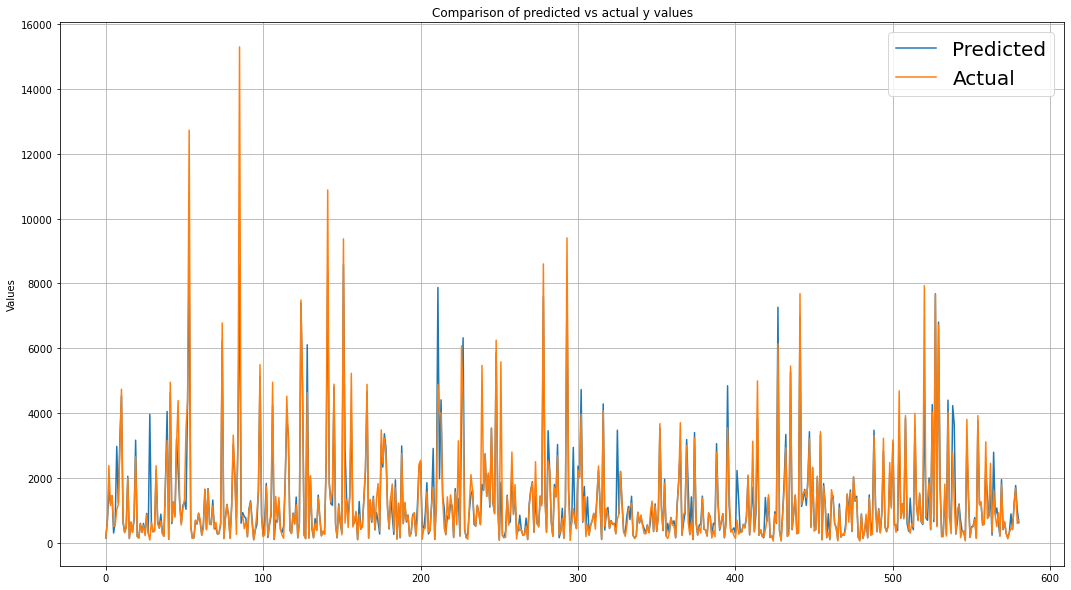

In [ ]:
get_metric(optimal_rf,True)

Random Forest regressor is overfitted. Possible as tree based models are prone to overfitting

## LGBM 

In [ ]:
lgbm_reg = LGBMRegressor()
lgbm_reg.fit(X_train,y_train)

LGBMRegressor()

In [ ]:
r2_score(y_train,lgbm_reg.predict(X_train))

0.967454294361459

In [ ]:
r2_score(y_test,lgbm_reg.predict(X_test))

0.8642526348201027

In [ ]:
lgbm_param = {
              "n_estimators" :[50,100,150],
              'num_leaves': [6,8,12,16],
              "max_depth": [2,4,5],
              "learning_rate": [0.01,0.05,0.1]
              }

In [ ]:
lgbm_grid = GridSearchCV(estimator=lgbm_reg,
                       param_grid = lgbm_param,n_jobs=6,
                       cv = 5, verbose=2, scoring='r2')

In [ ]:
lgbm_grid.fit(X_train,y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=6,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 4, 5], 'n_estimators': [50, 100, 150],
                         'num_leaves': [6, 8, 12, 16]},
             scoring='r2', verbose=2)

In [ ]:
lgbm_optimal = lgbm_grid.best_estimator_

Different metric scores are summed up in the dataframe below:- 




,Train,Test
R2,0.888,0.861
Adjusted-R2,0.874,0.844
Mean Absolute error,221.824,263.523
Mean square error,260859.179,392336.897
Root mean Squared error,510.744,626.368


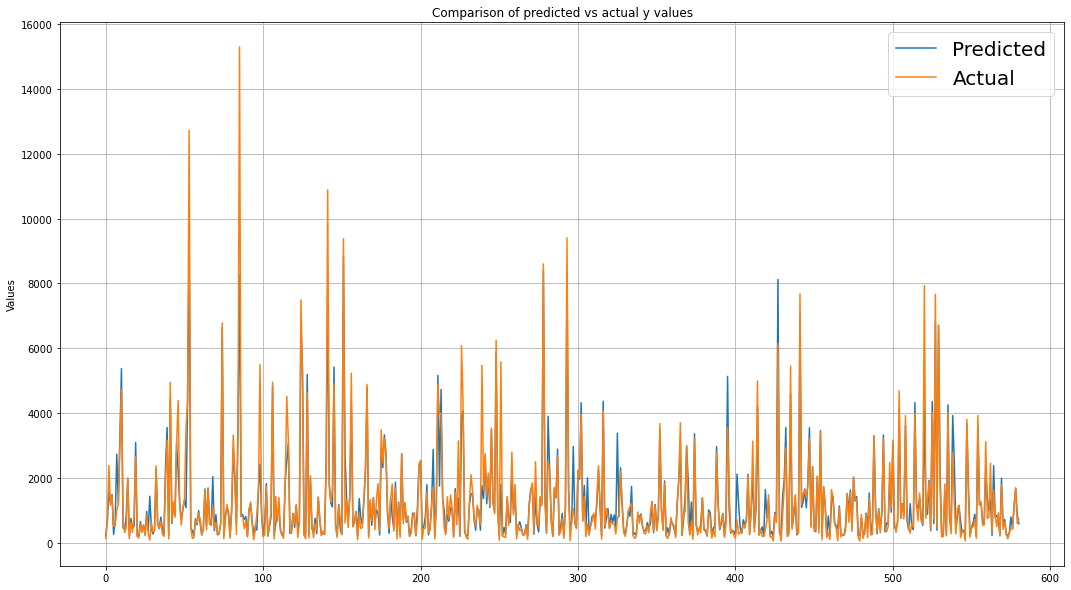

In [ ]:
get_metric(lgbm_optimal,True)

LGBM is performing great. The model is not overfitted and training and testing scores are very close to each other.

## CatBoost

In [ ]:
cat_reg = CatBoostRegressor()
cat_reg.fit(X_train,y_train)

Learning rate set to 0.046778
0:	learn: 1482.0215338	total: 287ms	remaining: 4m 47s
1:	learn: 1438.5325879	total: 326ms	remaining: 2m 42s
2:	learn: 1400.4596667	total: 377ms	remaining: 2m 5s
3:	learn: 1359.8308607	total: 422ms	remaining: 1m 45s
4:	learn: 1323.5369911	total: 469ms	remaining: 1m 33s
5:	learn: 1290.6719591	total: 652ms	remaining: 1m 47s
6:	learn: 1263.2221479	total: 721ms	remaining: 1m 42s
7:	learn: 1234.6875494	total: 765ms	remaining: 1m 34s
8:	learn: 1205.8232731	total: 810ms	remaining: 1m 29s
9:	learn: 1176.9251834	total: 851ms	remaining: 1m 24s
10:	learn: 1149.3152296	total: 900ms	remaining: 1m 20s
11:	learn: 1127.1108161	total: 939ms	remaining: 1m 17s
12:	learn: 1101.9117693	total: 985ms	remaining: 1m 14s
13:	learn: 1076.5920401	total: 1.05s	remaining: 1m 13s
14:	learn: 1052.2057644	total: 1.13s	remaining: 1m 14s
15:	learn: 1028.3487375	total: 1.22s	remaining: 1m 15s
16:	learn: 1009.5640763	total: 1.29s	remaining: 1m 14s
17:	learn: 990.8372282	total: 1.34s	remaining:

In [ ]:
cat_param = {'depth': [2,4,5],
             'learning_rate' : [0.01,0.05,0.1],
             'iterations'    : [150,200]
            }

In [ ]:
ct_grid = GridSearchCV(estimator=cat_reg,
                       param_grid = cat_param,n_jobs=9,
                       cv = 5, verbose=2, scoring='r2')

In [ ]:
ct_grid.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
0:	learn: 1431.6401341	total: 56ms	remaining: 11.1s
1:	learn: 1351.8262439	total: 88ms	remaining: 8.71s
2:	learn: 1279.1819528	total: 115ms	remaining: 7.54s
3:	learn: 1221.4400254	total: 144ms	remaining: 7.06s
4:	learn: 1164.6436977	total: 172ms	remaining: 6.72s
5:	learn: 1110.5073409	total: 201ms	remaining: 6.48s
6:	learn: 1060.7580395	total: 235ms	remaining: 6.49s
7:	learn: 1012.5064920	total: 262ms	remaining: 6.28s
8:	learn: 974.8220248	total: 287ms	remaining: 6.08s
9:	learn: 934.4460771	total: 314ms	remaining: 5.96s
10:	learn: 892.5677304	total: 343ms	remaining: 5.89s
11:	learn: 861.9532939	total: 374ms	remaining: 5.86s
12:	learn: 833.7359712	total: 408ms	remaining: 5.86s
13:	learn: 813.4544588	total: 441ms	remaining: 5.86s
14:	learn: 791.4868891	total: 472ms	remaining: 5.82s
15:	learn: 767.4301866	total: 507ms	remaining: 5.83s
16:	learn: 748.8925856	total: 545ms	remaining: 5.86s
17:	learn: 733.3569731	total: 582ms	remain

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000022972DE97C0>,
             n_jobs=9,
             param_grid={'depth': [2, 4, 5], 'iterations': [150, 200],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='r2', verbose=2)

In [ ]:
optimal_cat = ct_grid.best_estimator_

Different metric scores are summed up in the dataframe below:- 




,Train,Test
R2,0.969,0.866
Adjusted-R2,0.965,0.849
Mean Absolute error,161.159,266.115
Mean square error,71908.778,377997.191
Root mean Squared error,268.158,614.815


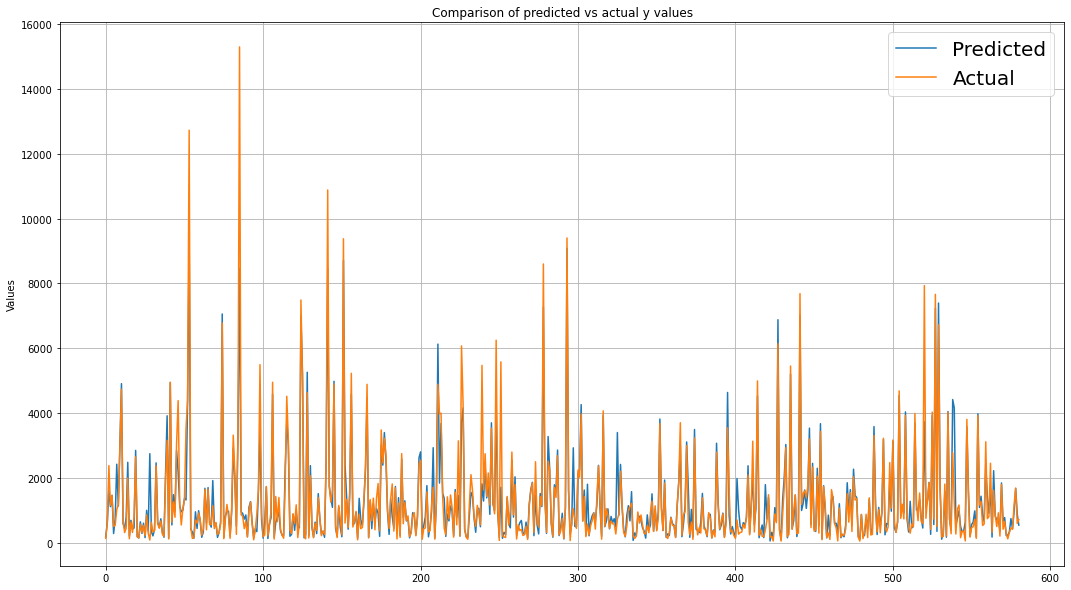

In [ ]:
get_metric(optimal_cat,True)

CatBoost is suffering from overfitting.

## XGBoost

In [ ]:
xgb_reg = XGBRegressor()

In [ ]:
xgb_reg.fit(X_train,y_train)

[17:20:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
r2_score(y_train,xgb_reg.predict(X_train))

0.999988060375447

In [ ]:
r2_score(y_test,xgb_reg.predict(X_test))

0.8657967308092374

In [ ]:
xgb_param = {'n_estimators': [50,100,150,200],
            'max_depth': [2,4,5,10],
            'learning_rate':[0.01,0.05,0.1]
            }

In [ ]:
xgb_grid = GridSearchCV(estimator=xgb_reg,
                       param_grid = xgb_param,n_jobs=9,
                       cv = 5, verbose=2, scoring='r2')

In [ ]:
xgb_grid.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1,
                                    enable_categorical=False, gamma=0,
                                    gpu_id=-1, importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=12,
                                    num_parallel_tree=1, predictor='auto',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', val

In [ ]:
optimal_xgb = xgb_grid.best_estimator_

Different metric scores are summed up in the dataframe below:- 




,Train,Test
R2,0.919,0.838
Adjusted-R2,0.908,0.817
Mean Absolute error,208.516,267.807
Mean square error,189423.016,458576.571
Root mean Squared error,435.228,677.183


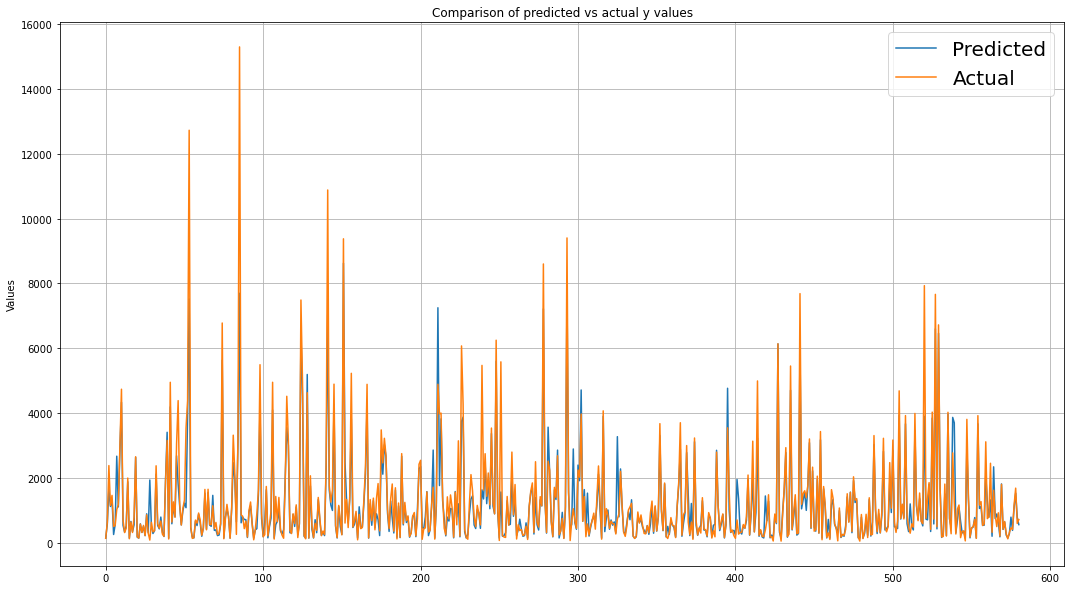

In [ ]:
get_metric(optimal_xgb,True)

We were able to improve the performance of XGBoost regressor after hyperparameter tuning. The overfitting is still present but to a lesser extent

## StackingRegressor

In [ ]:
stack_estimator = [('rf',optimal_rf),
                   ('lgbm',lgbm_optimal),
                   ('cat',optimal_cat),
                   ('xgb',optimal_xgb)
                  ]
stack_reg = StackingRegressor(estimators=stack_estimator,final_estimator=lgbm_optimal,cv=5,verbose=2,n_jobs=9)

In [ ]:
stack_reg.fit(X_train,y_train)

StackingRegressor(cv=5,
                  estimators=[('rf',
                               RandomForestRegressor(max_depth=6,
                                                     max_leaf_nodes=150,
                                                     n_estimators=250)),
                              ('lgbm',
                               LGBMRegressor(learning_rate=0.05, max_depth=5,
                                             num_leaves=6)),
                              ('cat',
                               <catboost.core.CatBoostRegressor object at 0x000002297377F6D0>),
                              ('xgb',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_...
                                            max_delta_step=0, max_depth=4,
                                     

Different metric scores are summed up in the dataframe below:- 




,Train,Test
R2,0.893,0.862
Adjusted-R2,0.880,0.844
Mean Absolute error,202.026,257.121
Mean square error,248350.496,391433.283
Root mean Squared error,498.348,625.646


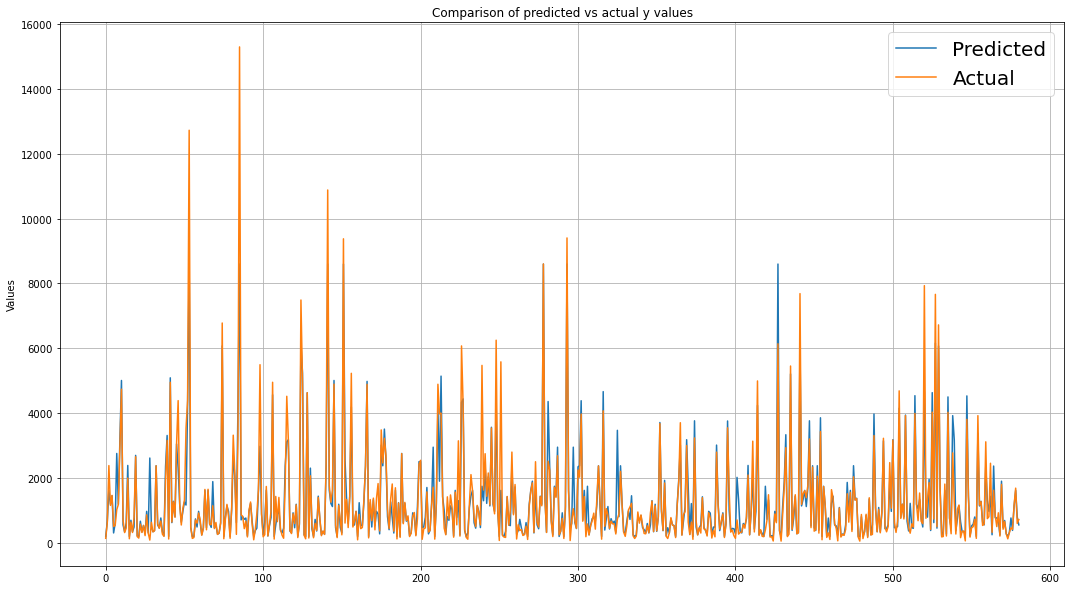

In [ ]:
get_metric(stack_reg,True)

Stacking regressor is also performing good.

## Voting Regressor

In [ ]:
vot_reg = VotingRegressor(estimators=stack_estimator,verbose=2,n_jobs=9)
vot_reg.fit(X_train,y_train)

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(max_depth=6,
                                                   max_leaf_nodes=150,
                                                   n_estimators=250)),
                            ('lgbm',
                             LGBMRegressor(learning_rate=0.05, max_depth=5,
                                           num_leaves=6)),
                            ('cat',
                             <catboost.core.CatBoostRegressor object at 0x000002297377F6D0>),
                            ('xgb',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=...
                                          gpu_id=-1, importance_type=None,
                                          interaction_constraints='',
            

Different metric scores are summed up in the dataframe below:- 




,Train,Test
R2,0.937,0.863
Adjusted-R2,0.929,0.845
Mean Absolute error,175.346,242.501
Mean square error,145651.178,387933.649
Root mean Squared error,381.643,622.843


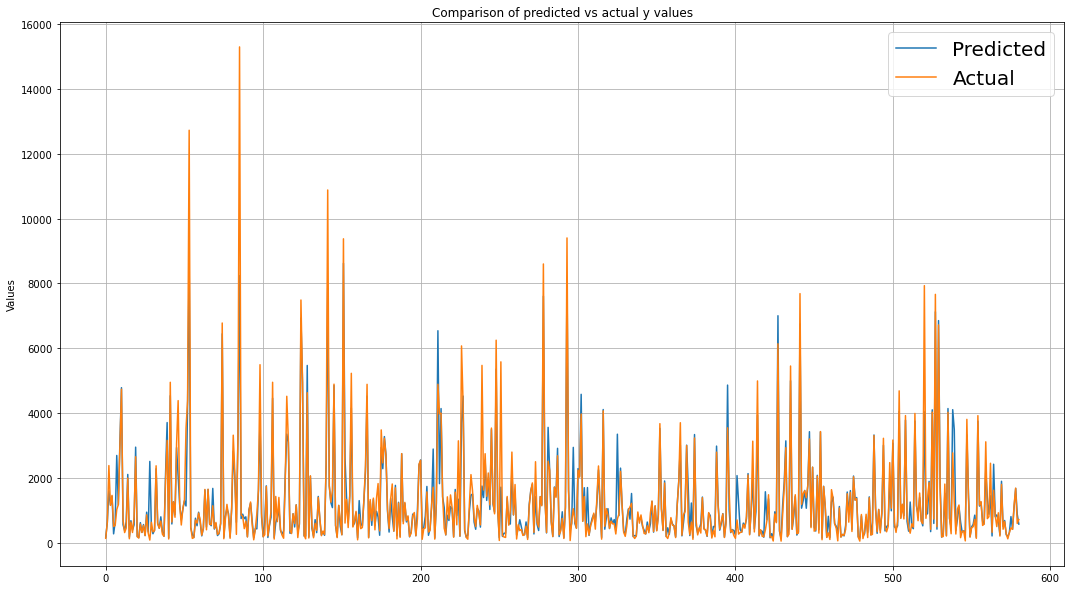

In [ ]:
get_metric(vot_reg,True)

Voting model is overfitted.

In [ ]:
regressors = [optimal_rf,lgbm_optimal,optimal_cat,optimal_xgb,stack_reg,vot_reg]
reg_names = ['RandomForest','LGBM','CatBoost','XGBoost','Stacking','Voting']
training,testing = [],[]
for i in regressors:
    tr = round(r2_score(y_train,i.predict(X_train)),3)
    ts = round(r2_score(y_test,i.predict(X_test)),3)
    training.append(tr)
    testing.append(ts)

In [ ]:
diff = np.array(training)-np.array(testing)
np.argmin(diff)

1

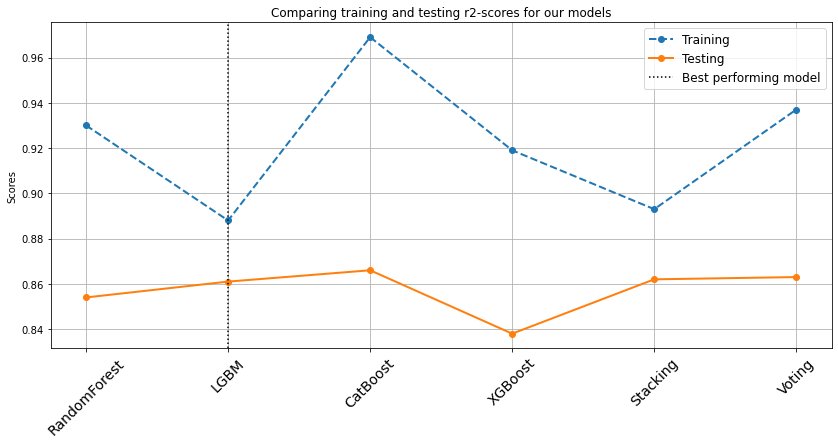

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(range(0,len(regressors)),training,'--o',lw=2,label='Training')
plt.plot(range(0,len(regressors)),testing,'-o',lw=2,label='Testing')
plt.xticks(range(0,len(regressors)), reg_names, rotation=45,fontsize=14)
plt.axvline(np.argmin(diff),linestyle=':', color='black', label=f'Best performing model')
plt.ylabel("Scores")
plt.title("Comparing training and testing r2-scores for our models")
plt.grid(True)
plt.legend(loc='best',fontsize=12);

## Conclusion:

> After comparing the performances of various regression models, we can say that LGBM Regressor is the best performer. 

> It is free from overfitting and training and testing scores are close.

> CatBoost Regressor is the worst performing model. Even after hyperparameter tuning done twice on it, overfitting still persisted.

> Stacking Regressor was based on many estimators but the final_estimator argument was LGBM so it also performed extraordinarily.
